In [78]:
"""Calculate results of comparing Kinect and Zeno gait metrics."""

import os
import glob

import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr

import analysis.stats as st


def combine_trials(load_dir, matched_file_names):
    """Combine dataframes from all matched walking trials."""
    list_dfs = []

    for i, file_name in enumerate(matched_file_names):

        file_path = os.path.join(load_dir, file_name + '.pkl')

        df_device = pd.read_pickle(file_path)
        df_device['trial_id'] = i

        list_dfs.append(df_device)

    return pd.concat(list_dfs).reset_index(drop=True)


load_dir_k = os.path.join('..', '..', 'data', 'kinect', 'gait_params')
load_dir_z = os.path.join('..', '..','data', 'zeno', 'gait_params')
match_dir = os.path.join('..', '..', 'data', 'matching')

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0).reset_index(drop=True)

file_paths_k = sorted(glob.glob(os.path.join(load_dir_k, '*.pkl')))
file_paths_z = sorted(glob.glob(os.path.join(load_dir_z, '*.pkl')))

# Convert match table to dictionary for easy file matching
dict_match = {x.Zeno: x.Kinect for x in df_match.itertuples()}

matched_file_names_k = list(dict_match.values())
matched_file_names_z = list(dict_match.keys())

df_total_k = combine_trials(load_dir_k, matched_file_names_k)
df_total_z = combine_trials(load_dir_z, matched_file_names_z)

# Columns that represent gait parameters
gait_params = df_total_k.select_dtypes(float).columns

# Remove negative values from Zeno data
df_total_z = df_total_z.applymap(
    lambda x: np.nan if isinstance(x, float) and x < 0 else x)

df_trials_k = df_total_k.groupby('trial_id').median()[gait_params]
df_trials_z = df_total_z.groupby('trial_id').median()[gait_params]

df_sides_k = df_total_k.groupby(['trial_id', 'side']).median()[gait_params]
df_sides_z = df_total_z.groupby(['trial_id', 'side']).median()[gait_params]

# Functions for results
# funcs = {
#     'pearson': lambda a, b: pearsonr(a, b)[0],
#     'spearman': lambda a, b: spearmanr(a, b)[0],
#     'abs_rel_error':
#     lambda a, b: st.relative_error(a, b, absolute=True).mean(),
#     'bias': lambda a, b: st.bland_altman(a, b).bias,
#     'range': lambda a, b: st.bland_altman(a, b).range_,
# }

bland_altman_funcs = {
     'bias': lambda a, b: st.bland_altman(st.relative_difference(a, b)).bias,
    'lower_limit': lambda a, b: st.bland_altman(st.relative_difference(a, b)).lower_limit,
    'upper_limit': lambda a, b: st.bland_altman(st.relative_difference(a, b)).upper_limit,
     'range': lambda a, b: st.bland_altman(st.relative_difference(a, b)).range_,
}

df_results_L = st.compare_measurements(df_sides_k.xs('L', level='side'), 
                                       df_sides_z.xs('L', level='side'), bland_altman_funcs).astype(float)

df_results_R = st.compare_measurements(df_sides_k.xs('R', level='side'), 
                                       df_sides_z.xs('R', level='side'), bland_altman_funcs).astype(float)


df_results = st.compare_measurements(df_trials_k, df_trials_z, bland_altman_funcs).astype(float)

In [79]:
df_results.round(3)

,stance_percentage,stance_percentage_double,step_length,stride_length,stride_time,stride_velocity,stride_width
bias,0.070,0.212,0.017,0.009,-0.170,0.165,0.342
lower_limit,-0.080,-0.320,-0.029,-0.027,-0.303,0.026,-0.347
upper_limit,0.220,0.745,0.063,0.045,-0.037,0.305,1.032
range,0.301,1.066,0.092,0.072,0.266,0.279,1.379


In [80]:
df_results_R

,stance_percentage,stance_percentage_double,step_length,stride_length,stride_time,stride_velocity,stride_width
bias,0.053617,0.165050,-0.022960,0.014517,-0.149079,0.154462,0.341931
lower_limit,-0.170225,-0.361160,-0.088113,-0.033687,-0.303894,-0.001524,-0.322514
upper_limit,0.277458,0.691259,0.042192,0.062721,0.005737,0.310447,1.006377
range,0.447683,1.052419,0.130305,0.096408,0.309631,0.311972,1.328891


In [81]:
df_results_L

,stance_percentage,stance_percentage_double,step_length,stride_length,stride_time,stride_velocity,stride_width
bias,0.068397,0.209892,0.055244,0.002442,-0.182111,0.173391,0.270116
lower_limit,-0.116296,-0.319013,-0.014462,-0.053375,-0.335995,0.023835,-0.590439
upper_limit,0.253091,0.738796,0.124949,0.058259,-0.028227,0.322947,1.130671
range,0.369387,1.057809,0.139411,0.111634,0.307768,0.299113,1.721110


In [82]:
index_sides = pd.MultiIndex.from_product((gait_params, ['L', 'R']), names=['param', 'side'])
df = pd.DataFrame(index=bland_altman_funcs.keys(), columns=index_sides)

In [83]:
df = pd.concat([df_results_L, df_results_R], keys=['L','R'],axis=1)
df.columns = df.columns.swaplevel(0, 1)
df = df.sort_index(level=0, axis=1)

df.round(3)

stance_percentage        stance_percentage_double         \
                            L      R                        L      R   
bias                    0.068  0.054                    0.210  0.165   
lower_limit            -0.116 -0.170                   -0.319 -0.361   
upper_limit             0.253  0.277                    0.739  0.691   
range                   0.369  0.448                    1.058  1.052   

            step_length        stride_length        stride_time         \
                      L      R             L      R           L      R   
bias              0.055 -0.023         0.002  0.015      -0.182 -0.149   
lower_limit      -0.014 -0.088        -0.053 -0.034      -0.336 -0.304   
upper_limit       0.125  0.042         0.058  0.063      -0.028  0.006   
range             0.139  0.130         0.112  0.096       0.308  0.310   

            stride_velocity        stride_width         
                          L      R            L      R  
bias                  0.173  0.154        0.270  0.342  
lower_limit           0.024 -0.002       -0.590 -0.323  
upper_limit           0.323  0.310        1.131  1.006  
range                 0.299  0.312        1.721  1.329

In [68]:
df_results_L.join(df_results_R, lsuffix='_L', rsuffix='_R')

,stance_percentage_L,stance_percentage_double_L,step_length_L,stride_length_L,stride_time_L,stride_velocity_L,stride_width_L,stance_percentage_R,stance_percentage_double_R,step_length_R,stride_length_R,stride_time_R,stride_velocity_R,stride_width_R
bias,0.0683974,0.209892,0.0552438,0.00244185,-0.182111,0.173391,0.270116,0.0536166,0.16505,-0.0229603,0.0145174,-0.149079,0.154462,0.341931
lower_limit,-0.116296,-0.319013,-0.0144618,-0.0533752,-0.335995,0.0238346,-0.590439,-0.170225,-0.36116,-0.088113,-0.0336866,-0.303894,-0.00152414,-0.322514
upper_limit,0.253091,0.738796,0.124949,0.0582589,-0.0282272,0.322947,1.13067,0.277458,0.691259,0.0421924,0.0627214,0.00573703,0.310447,1.00638
range,0.369387,1.05781,0.139411,0.111634,0.307768,0.299113,1.72111,0.447683,1.05242,0.130305,0.096408,0.309631,0.311972,1.32889


## Plots

In [5]:
import matplotlib.pyplot as plt

import analysis.math_funcs as mf
import analysis.plotting as pl

In [7]:
plt.rc('text', usetex=True)

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 14,
       }

plt.rc('font', **font)  # pass in the font dict as kwargs

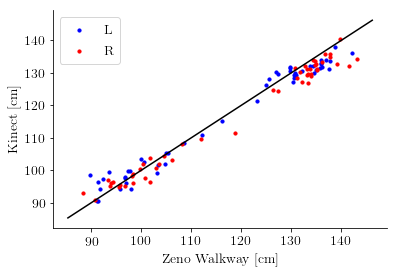

In [10]:
param = 'stride_length'

_, ax = plt.subplots()

scatter_l = ax.scatter(df_sides_k.xs('L', level='side')[param],
                        df_sides_z.xs('L', level='side')[param],
                        c='b', s=10)

scatter_r = ax.scatter(df_sides_k.xs('R', level='side')[param],
                        df_sides_z.xs('R', level='side')[param],
                        c='r', s=10)

ax.legend([scatter_l, scatter_r], ['L', 'R'])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]

# Plot equality line
ax.plot(lims, lims, 'k-')

# Remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("Zeno Walkway [cm]")
plt.ylabel("Kinect [cm]")

plt.show()

## Bland altman

In [11]:
rel_diffs_l = st.relative_difference(df_sides_k.xs('L', level='side')[param],
                                     df_sides_z.xs('L', level='side')[param])

In [12]:
# bland_alt_l = st.bland_altman(df_sides_k.xs('L', level='side')[param],
#                               df_sides_z.xs('L', level='side')[param])

# bland_alt_r = st.bland_altman(df_sides_k.xs('R', level='side')[param],
#                               df_sides_z.xs('R', level='side')[param])

# Bland altman of both left and right points
bland_alt_both = st.bland_altman(st.relative_difference(df_sides_k[param], df_sides_z[param]))

In [13]:
# bland_alt_grouped = st.bland_altman(df_trials_k[param], df_trials_z[param])

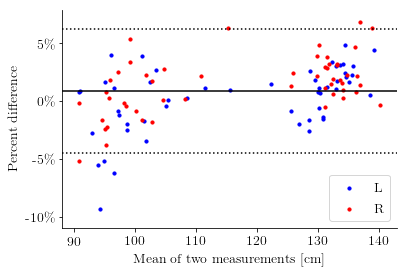

In [14]:
_, ax = plt.subplots()

# ax.scatter(bland_alt_l.means, bland_alt_l.rel_diffs, c='b', s=10)
# ax.scatter(bland_alt_r.means, bland_alt_r.rel_diffs, c='r', s=10)

# ax.scatter(bland_alt_grouped.means, bland_alt_grouped.rel_diffs, c='r', s=10)

pl.scatter_bland(ax, df_sides_k.xs('L', level='side')[param], 
                 df_sides_z.xs('L', level='side')[param],
                c='b', s=10)

pl.scatter_bland(ax, df_sides_k.xs('R', level='side')[param], 
                 df_sides_z.xs('R', level='side')[param],
                c='r', s=10)

ax.legend([scatter_l, scatter_r], ['L', 'R'])

# Remove right and top borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Horizontal lines for bias and limits of agreement
ax.axhline(y=bland_alt_both.bias, color='k', linestyle='-')
ax.axhline(y=bland_alt_both.lower_limit, color='k', linestyle=':')
ax.axhline(y=bland_alt_both.upper_limit, color='k', linestyle=':')

# Format y labels as percentages
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in ax.get_yticks()])

plt.xlabel('Mean of two measurements [cm]')
plt.ylabel('Percent difference')

plt.show()